SQL BigQuery

```
SELECT * FROM `ftds-hacktiv8-project.phase1_ftds_016_rmt.heart-failure`
```

# Problems

> Buatlah model Classification menggunakan Random Forest dan salah satu algoritma boosting untuk memprediksi apakah seorang pasien akan meninggal atau tidak menggunakan dataset yang sudah Anda dapatkan.

# Conceptual Problems

1. Apakah yang dimaksud dengan Bagging?

  Bagging is a method used by `sklearn.ensemble.RandomForestClassifier` to aggregates voting between multiple decision tree classifier to predict a single instance.

2. Jelaskan perbedaan algoritma Random Forest dengan algoritma boosting yang Anda pilih?

  `sklearn.ensemble.RandomForestClassifier` aggregates voting between multiple decision tree classifier to predict a single instance. The Decision Tree Classifier is built based on the bootstrap set (i.e. bootstrap set that is the entire train set or perhaps just a portion of the train set, we can configure it by tuning the parameters `max_samples` from 0.0 to 1.0 and make sure to set the `bootstrap=True`). The bootstrap set for each Decision Tree Classifier can be different or the same (it's random).

  Duly noted, if we were to compare `sklearn.ensemble.RandomForestClassifier` with `xgboost.XGBClassifier`, notice that the decision tree made in RandomForestClassifier is not based on the previous decision tree. This is because RandomForestClassifier built the tree parallel while XGBClassifier builds the tree sequentially.

  `xgboost.XGBClassifier` or Gradient Boosting built multiple decision tree classifier sequentially (the first step is to create a leaf / prediction and calculates the residuals, the next decision tree is built based on the errors made by the previous tree and so on). However, this method is more prone to overfitting than the bagging method. This is where parameter `learning_rate` comes to the rescue. It scales the contribution of the next decision tree.
  
  Duly noted, if we were to compare `xgboost.XGBClassifier` with `sklearn.ensemble.AdaBoostClassifier`, notice that the scale for Gradient Boosting is the same while AdaBoost isn't (although we can tune the 'learning_rate' parameter as well, under the hood each decision tree have different scale). This is because the algorithm determines the scale (based on how well the next decision tree corrected the previous decision tree errors), not us.

# 1 - Perkenalan

Name : Jason Rich Darmawn Onggo Putra

Batch : 016 RMT

Dataset Overview: These dataset contains 12 features that can be used to predict whether a person that had heart attack will survive or not.

Objective : Create a model based on Random Forest algorithm and XGBoost algorithm.

# 2 - Import Libraries

In [78]:
# Data Loading
import pandas as pd

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler

# 3 - Data Loading

In [2]:
# load the dataset
dt = pd.read_csv("./h8dsft_P1G3_jason_rich_darmawan_onggo_putra.csv")

# head and tail preview
dt

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,42.0,1,250,1,15,0,213000.00,1.3,136,0,0,65,1
1,46.0,0,168,1,17,1,271000.00,2.1,124,0,0,100,1
2,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
3,53.0,1,91,0,20,1,418000.00,1.4,139,0,0,43,1
4,50.0,1,582,1,20,1,279000.00,1.0,134,0,0,186,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,63.0,1,122,1,60,0,267000.00,1.2,145,1,0,147,0
295,45.0,0,308,1,60,1,377000.00,1.0,136,1,0,186,0
296,70.0,0,97,0,60,1,220000.00,0.9,138,1,0,186,0
297,53.0,1,446,0,60,1,263358.03,1.0,139,1,0,215,0


## 3.1 - Column Dtypes

Insights:
- 'age'
  > [age is a continuous variable, ie people age all the time, they don't just age once a year, so the data type which most closely reflects the aging process should be a float and not an integer .](https://stackoverflow.com/questions/67329095/when-should-you-convert-age-column-in-float-or-int#:~:text=age%20is%20a%20continuous%20variable,float%20and%20not%20an%20integer%20.)

  Therefore, do not change age to 'int64'
- No missing values.

Features:
- numerical columns: ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
- nominal columns: ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

Target:
- nominal column: ['DEATH_EVENT']

In [6]:
# get cols dtypes
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [19]:
# define columns to be used by sklearn.compose.ColumnTransformer later.

num_cols = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 
            'serum_creatinine', 'serum_sodium', 'time']
nom_cols = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
target = 'DEATH_EVENT'

dt[nom_cols] = dt[nom_cols].astype('category')

# 4 - Exploratory Data Analysis (EDA)

### Ask Instructor

- If we know the boundary e.g percentage boundary is 0% and 100%. Should we scale the data based on the boundary (i.e column 'ejection_fraction' 90 scaled to 0.9) or the train set (i.e column 'ejection_fraction' 90 scaled to X_std * (max - min) + min)?

## 4.1 - Central Tendency

- 'creatinine_phosphokinase' measured in microgram per liter.
  > [His measured creatine phosphokinase (CPK) is over 35,000 IU/liter.](https://www.clinicalcorrelations.org/2010/11/03/creatine-kinase-how-much-is-too-much/)

  After some research, we concluded that each enzyme have its own molecular weight. There is no clear scientific paper to explain on how to convert IU/L to mcg/L.

  We will assume that the outliers are natural outliers.

- 'platelets' measured in kiloplatelets/ml
  > [A normal platelet count ranges from 150,000 to 450,000 platelets per microliter of blood. Having more than 450,000 platelets is a condition called thrombocytosis; having less than 150,000 is known as thrombocytopenia. You get your platelet number from a routine blood test called a complete blood count (CBC).](https://www.hopkinsmedicine.org/health/conditions-and-diseases/what-are-platelets-and-why-are-they-important)

  450,000 platelets per microliter is equal to 450,000,000 platelets/ml and 450,000 kiloplatelets/ml.

  We will assume that the outliers are natural outliers.

- 'serum_creatinine' measured in mg/dL

  > [The typical range for serum creatinine is:  
  For adult men, 0.74 to 1.35 mg/dL (65.4 to 119.3 micromoles/L)  
  For adult women, 0.59 to 1.04 mg/dL (52.2 to 91.9 micromoles/L)](https://www.mayoclinic.org/tests-procedures/creatinine-test/about/pac-20384646#:~:text=The%20typical%20range%20for%20serum,52.2%20to%2091.9%20micromoles%2FL))

  We do not have domain knowledge for 'serum_creatinine' either. Although the max value in this dataset is 9.40 or almost 9 times (normal condition). We can only assume these outliers as natural outliers.

- 'serum_sodium' measured in 'mEq/dL'

  > [A normal blood sodium level is between 135 and 145 milliequivalents per liter (mEq/L). Hyponatremia occurs when the sodium in your blood falls below 135 mEq/L.](https://www.mayoclinic.org/diseases-conditions/hyponatremia/symptoms-causes/syc-20373711#:~:text=A%20normal%20blood%20sodium%20level,liter%20(mEq%2FL).)

  According to `mean + 3 * std`, no outliers.

In [11]:
# get central tendency

with pd.option_context('display.float_format', '{:.2f}'.format):
    display(dt[num_cols].describe())

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
count,299.00,299.00,299.00,299.00,299.00,299.00,299.00
mean,60.83,581.84,38.08,263358.03,1.39,136.63,130.26
std,11.89,970.29,11.83,97804.24,1.03,4.41,77.61
min,40.00,23.00,14.00,25100.00,0.50,113.00,4.00
25%,51.00,116.50,30.00,212500.00,0.90,134.00,73.00
50%,60.00,250.00,38.00,262000.00,1.10,137.00,115.00
75%,70.00,582.00,45.00,303500.00,1.40,140.00,203.00
max,95.00,7861.00,80.00,850000.00,9.40,148.00,285.00


In [14]:
# get central tendency
display(dt[nom_cols].describe())

,anaemia,diabetes,high_blood_pressure,sex,smoking
count,299,299,299,299,299
unique,2,2,2,2,2
top,0,0,0,1,0
freq,170,174,194,194,203


## 4.2 - Relationship between X and y

### 4.2.1 - X Numerical and y Nominal

good or not good separator for True Positive is based on:
1. visual boxplot
  - if the whiskes of TP is larger than the whiskes of TN, then good separator.
  - if not, then not good separator.

- 'age' good separator TP (1st)
  -  < 42 (min) : live
  - \> 90 (max) : die
- 'creatinine_phosphokinase' not good separator TP
  - < 30 (min) : die
  - \> 5209 (max) : die
- 'ejection_fraction' good separator TP (3nd)
  - < 35 (min) : die
  - \> 70 (max) : live
- 'platelets' good separator TP (4th)
  - < 47,000 : live
  - \> 62,1000 : live
- 'serum_creatine' good separator TP (2nd)
  - < 0.6 (min) : die
  - \> 6.1 (max) : die
- 'serum_sodium' good separator TP (5th)
  - < 116 (min) : live
  - \> 146 (max) : live
- 'time' not good separator TP
  - < 12 (min) : die
  - \> 241 (max) : live

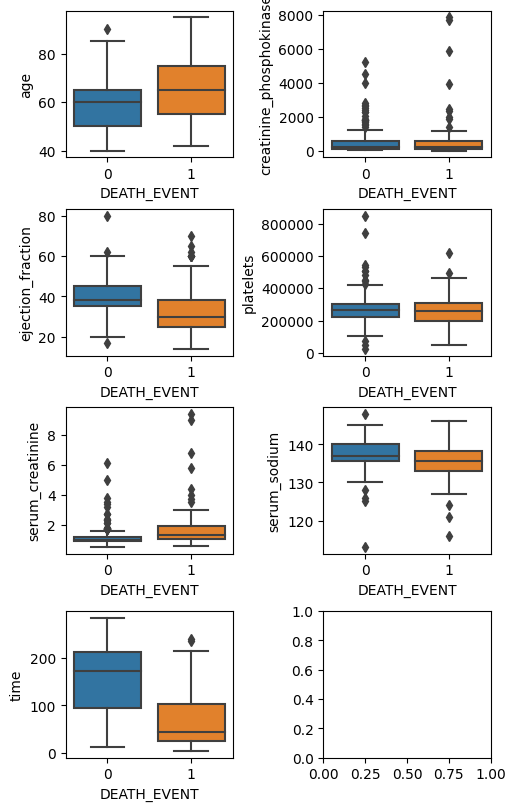

In [103]:
def isolate():
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(5,8), constrained_layout=True)
    for feature, ax in zip(num_cols, axes.ravel()):
        sns.boxplot(data=dt, x=target, y=feature, ax=ax)
isolate()

In [57]:
# get min max
# < 42 (min) : live
# > 90 (max) : die
dt[['age', target]].groupby(target).describe()

age                                                    
             count       mean        std   min   25%   50%   75%   max
DEATH_EVENT                                                           
0            203.0  58.761906  10.637890  40.0  50.0  60.0  65.0  90.0
1             96.0  65.215281  13.214556  42.0  55.0  65.0  75.0  95.0

In [58]:
# get min max
# < 30 (min) : die
# > 5209 (max) : die
dt[['creatinine_phosphokinase', target]].groupby(target).describe()

creatinine_phosphokinase                                         \
                               count        mean          std   min     25%   
DEATH_EVENT                                                                   
0                              203.0  540.054187   753.799572  30.0  109.00   
1                               96.0  670.197917  1316.580640  23.0  128.75   

                                   
               50%    75%     max  
DEATH_EVENT                        
0            245.0  582.0  5209.0  
1            259.0  582.0  7861.0

In [59]:
# get min max
# < 35 (min) : die
# > 70 (max) : live
dt[['ejection_fraction', target]].groupby(target).describe()

ejection_fraction                                               \
                        count      mean        std   min   25%   50%   75%   
DEATH_EVENT                                                                  
0                       203.0  40.26601  10.859963  17.0  35.0  38.0  45.0   
1                        96.0  33.46875  12.525303  14.0  25.0  30.0  38.0   

                   
              max  
DEATH_EVENT        
0            80.0  
1            70.0

In [61]:
# get min max
# < 47,000 : live
# > 62,1000 : live
dt[['platelets', target]].groupby(target).describe()

platelets                                                  \
                count           mean           std      min       25%   
DEATH_EVENT                                                             
0               203.0  266657.489901  97531.202283  25100.0  219500.0   
1                96.0  256381.044792  98525.682856  47000.0  197500.0   

                                           
                  50%       75%       max  
DEATH_EVENT                                
0            263000.0  302000.0  850000.0  
1            258500.0  311000.0  621000.0

In [60]:
# < 0.6 (min) : die
# > 6.1 (max) : die
dt[['serum_creatinine', target]].groupby(target).describe()

serum_creatinine                                               
                       count      mean       std  min    25%  50%  75%  max
DEATH_EVENT                                                                
0                      203.0  1.184877  0.654083  0.5  0.900  1.0  1.2  6.1
1                       96.0  1.835833  1.468562  0.6  1.075  1.3  1.9  9.4

In [62]:
# < 116 (min) : live
# > 146 (max) : live
dt[['serum_sodium', target]].groupby(target).describe()

serum_sodium                                                     \
                   count        mean       std    min    25%    50%     75%   
DEATH_EVENT                                                                   
0                  203.0  137.216749  3.982923  113.0  135.5  137.0  140.00   
1                   96.0  135.375000  5.001579  116.0  133.0  135.5  138.25   

                    
               max  
DEATH_EVENT         
0            148.0  
1            146.0

In [69]:
# < 12 (min) : die
# > 241 (max) : live
dt[['time', target]].groupby(target).describe()

time                                                         
             count        mean        std   min   25%    50%     75%    max
DEATH_EVENT                                                                
0            203.0  158.339901  67.742872  12.0  95.0  172.0  213.00  285.0
1             96.0   70.885417  62.378281   4.0  25.5   44.5  102.25  241.0

## 4.3 - Relationship X Nominal y Nominal

- 'anaemia' good separator TP (1st)
- 'diabetes' not good separator TP
- 'high_blood_pressure' good separator (2nd)
- 'sex' not good separator
- 'smoking' not good separator

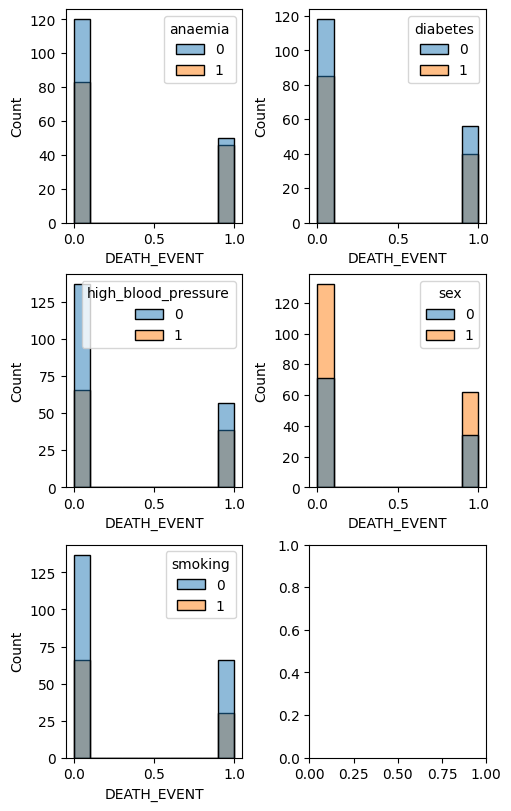

In [110]:
def isolate():
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(5,8), constrained_layout=True)
    for feature, ax in zip(nom_cols, axes.ravel()):
        sns.histplot(data=dt, x=target, hue=feature, ax=ax)
isolate()

## 4.4 - Imbalance Check

> [Mild 20-40% of the data set](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data)

The dataset is mildly imbalanced.

In [112]:
# mildly imbalanced dataset
dt[target].value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

# 5 - Data Preprocessing

## 5.1 - Pipeline